### Курсовой проект по курсу: 
### Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

#### План:

1. Подключение библиотек и скриптов
2. Загрузка данных
3. EDA
4. Обработка выбросов
5. Обработка пропусков
6. Построение новых признаков
7. Отбор признаков
8. Разбиение на train и test
9. Построение модели
10. Прогнозирование на тестовом датасете

#### 1. Подключение библиотек и скриптов

In [1]:
# Импорт основных библиотек
import joblib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 14})

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime
import random
import seaborn as sns

In [2]:
# Пути к файлам
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [3]:
def reduce_mem_usage(df):
    """ Modify the data type to reduce memory usage. """
    start_memory = df.memory_usage().sum() / 1024**2
    print(f'Dataframe memory usage: {round(start_memory, 2)} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':            
                if c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    finish_memory = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {round(finish_memory, 2)} MB')
    
    return df

In [4]:
def build_hist_one_col(df, col):
    plt.figure(figsize=(8, 4))
    df[col].hist(bins=30)
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.title(f'Распределение признака {col}')
    plt.show()

In [5]:
def build_histogram(df):
    for col in df.columns[2:]:
        if str(df[col].dtype)[:3] in 'intflo':
            plt.figure(figsize=(8, 4))
            df[col].hist(bins=100)
            plt.ylabel('Count')
            plt.xlabel(col)
            plt.axis([0, df[col].max(), 0, 10])
            plt.title(f'Распределение признака {col}')
            plt.show()

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### 2. Загрузка даннных.

##### Загрузка тренировчного датасета.

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


##### Описание датасета

* **Id** - идентификационный номер квартиры

* **DistrictId** - идентификационный номер района

* **Rooms** - количество комнат

* **Square** - площадь

* **LifeSquare** - жилая площадь

* **KitchenSquare** - площадь кухни

* **Floor** - этаж

* **HouseFloor** - количество этажей в доме

* **HouseYear** - год постройки дома

* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности

* **Social_1, Social_2, Social_3** - социальные показатели местности

* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья

* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров

* **Price** - цена квартиры

In [8]:
# train_df.info()

##### Загрузка тестового датасета

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [11]:
print(f'Строк в трейне: {train_df.shape[0]}')
print(f'Строк в тесте: {test_df.shape[0]}')

Строк в трейне: 10000
Строк в тесте: 5000


##### Сравнение количества признаков в обоих датафреймах.

In [12]:
train_df.shape[1] - 1 == test_df.shape[1]

True

##### Понижение размера памяти датафреймов.

In [13]:
print('train:')
train_df = reduce_mem_usage(train_df)
print('\ntest:')
test_df = reduce_mem_usage(test_df)

train:
Dataframe memory usage: 1.53 MB
Memory usage after optimization: 0.49 MB

test:
Dataframe memory usage: 0.72 MB
Memory usage after optimization: 0.22 MB


In [14]:
# train_df.info()

In [15]:
# test_df.info()

Т.к. признаки Id и DistrictId фактически не являются количественными, приведем их к строковому типу, что бы они не оказывали влияние на обучение модели.

In [16]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

#### 3. EDA (первичный анализ данных для обработки выбросов и пропусков, формирование идей для генерации новых фич).

Визуальная проверка распределения целевой переменной

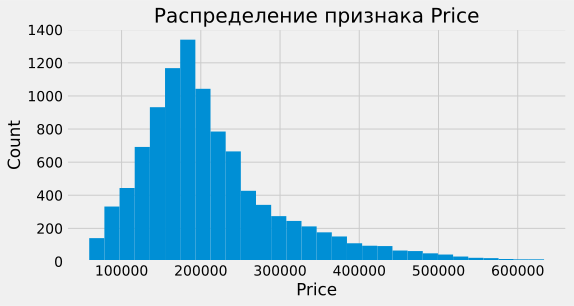

In [17]:
build_hist_one_col(train_df, 'Price')

Визуально заметно отсутствие аномалий в целевой переменной. Выглядит правдоподобно.

##### Просмотрим количественные переменные:

In [18]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


При первом просмотре заметны следующие аномалии:
* Имеются пропуски по признакам LifeSquare, Healthcare_1;
* В признаке LifeSquare минимальное значение равно 0.37m2, что указывает на явный выброс;
* В признаке Square минимальное значение равно 1.14m2, что так же указывает на выброс;
* В признаке Kitchensquare минимальное значение равно 0m2;
* В признаке HouseFloor минимальное значение равно 0, чего в принципе не бывает. К тому же минимальное значение Floor равно 1;
* Стоит обратить внимание на признак Rooms, т.к. минимальное значение равно 0. Возможно имеется в виду квартиры-студии. Также максимальное значение для данного признака равно 19. Больше похоже на выброс;
* Также на явный выброс указаывают максимальные значения признаков LifeSquare и KitchenSquare - каждый из них по отдельности превосходит в несколько раз максимальное значение признака Square;
* Необходимо отметить выброс в признаке HouseFloor, где максимальное значение указывает на здание в 117 этажей, тогда как, по данным Википедии, на данный момент самое высокое здание в Москве имеет 95 этажей;

##### Просмотрим распределение количественных признаков с помощью гистограм.
Для этого используем функцию построения гистограм.
Что бы рассмотреть выбросы ограничим ось ординат значением 10.

In [19]:
# build_histogram(train_df)

Гистограммы подтверждают первоначальные наблюдения.

#### 4. Обработка выбросов

##### Проверим площадь квартир с количеством комнат выше, либо равной 6.

In [20]:
train_df[(train_df['Rooms'] >= 6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
2728,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625
6088,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
8794,14003,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750


Наличие выбросов очевидно. Поэтому обработаем данный признак.

In [21]:
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'] // 10
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

train_df['Rooms'].value_counts()

2.0    3880
1.0    3717
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

##### Обработаем признак KitchenSquare.

In [22]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [23]:
(train_df['KitchenSquare'] == 0).sum()

697

##### Просмотрим квартили этого признака

In [24]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [25]:
train_df['KitchenSquare'].isna().sum()

0

##### Заполним пропуски и выбросы

In [26]:
condition = (train_df['KitchenSquare'].isna()) \
            | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) \
            | (train_df['KitchenSquare'] == 0)
        
train_df.loc[condition, 'KitchenSquare'] = train_df['Square'] * .2

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [27]:
train_df['KitchenSquare'].value_counts()

3.000000     2488
8.000000     1306
5.000000     1169
10.000000    1075
6.000000     1038
             ... 
8.860126        1
8.413872        1
13.768214       1
8.910792        1
16.897215       1
Name: KitchenSquare, Length: 895, dtype: int64

In [28]:
# train_df['KitchenSquare'].max()
# train_df['KitchenSquare'].isna().sum()

In [29]:
# build_hist_one_col(train_df, 'KitchenSquare')

##### Обработаем признаки HouseFloor и Floor.

In [30]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [31]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [32]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [33]:
(train_df['HouseFloor'] == 0).sum()

269

In [34]:
condition_2 = (train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] > 90)
train_df.loc[condition_2, 'HouseFloor'] = train_df['Floor']

condition_3 = (train_df['Floor'] > train_df['HouseFloor'])
train_df.loc[condition_3, 'Floor'] = train_df['HouseFloor']

(train_df['HouseFloor'] == 0).sum(), (train_df['Floor'] > train_df['HouseFloor']).sum()

(0, 0)

In [35]:
# build_hist_one_col(train_df, 'HouseFloor')

In [36]:
# build_hist_one_col(train_df, 'Floor')

##### Обработаем признак HouseYear.

In [37]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [38]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

#### 5. Обработка пропусков

In [39]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

У признака Healthcare_1 пропусков около половины всех наблюдений, поэтому отбросим его.

In [40]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

##### Обработаем признак LifeSquare

##### Заполним пропуски

In [41]:
expression = (train_df['Square'] * .9 - train_df['KitchenSquare'])
train_df.loc[(train_df['LifeSquare'].isna()), 'LifeSquare'] = expression

In [42]:
# build_hist_one_col(train_df, 'LifeSquare')

In [43]:
# train_df['LifeSquare'].isna().sum()

##### Исправим выбросы

In [44]:
condition_3 = (train_df['LifeSquare'] > expression)
train_df.loc[condition_3, 'LifeSquare'] = expression

In [45]:
# build_hist_one_col(train_df, 'LifeSquare')

In [46]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
    def transform(self, X):
        """Трансформация данных"""
        
        # Rooms
        X.loc[X['Rooms'] >= 6, 'Rooms'] = X['Rooms'] // 10
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
            | (X['KitchenSquare'] > self.kitchen_square_quantile) \
            | (X['KitchenSquare'] == 0)
        
        X.loc[condition, 'KitchenSquare'] = X['Square'] * .2

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        condition_2 = (X['HouseFloor'] == 0) | (X['HouseFloor'] > 90)
        X.loc[condition_2, 'HouseFloor'] = X['Floor']

        condition_3 = (X['Floor'] > X['HouseFloor'])
        X.loc[condition_3, 'Floor'] = X['HouseFloor']

        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        expression = (X['Square'] * .9 - X['KitchenSquare'])
        X.loc[(X['LifeSquare'].isna()), 'LifeSquare'] = expression
        
        condition_3 = (X['LifeSquare'] > expression)
        X.loc[condition_3, 'LifeSquare'] = expression
    
        X.fillna(self.medians, inplace=True)
        
        return X

#### 6. Построение новых признаков

##### Dummies

In [47]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

In [48]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [49]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,11809,27,3.0,115.027313,93.524582,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000,851
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875,78
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750,652
3,2352,1,1.0,40.409908,33.368916,3.0,10.0,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.000000,652
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.093750,89


In [50]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [51]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [52]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
             
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
        

In [53]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

target_name = 'Price'

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

In [55]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7500, 19), (2500, 19), (5000, 19))

In [56]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7500, 22), (2500, 22), (5000, 22))

In [57]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.961
Test R2:	0.759


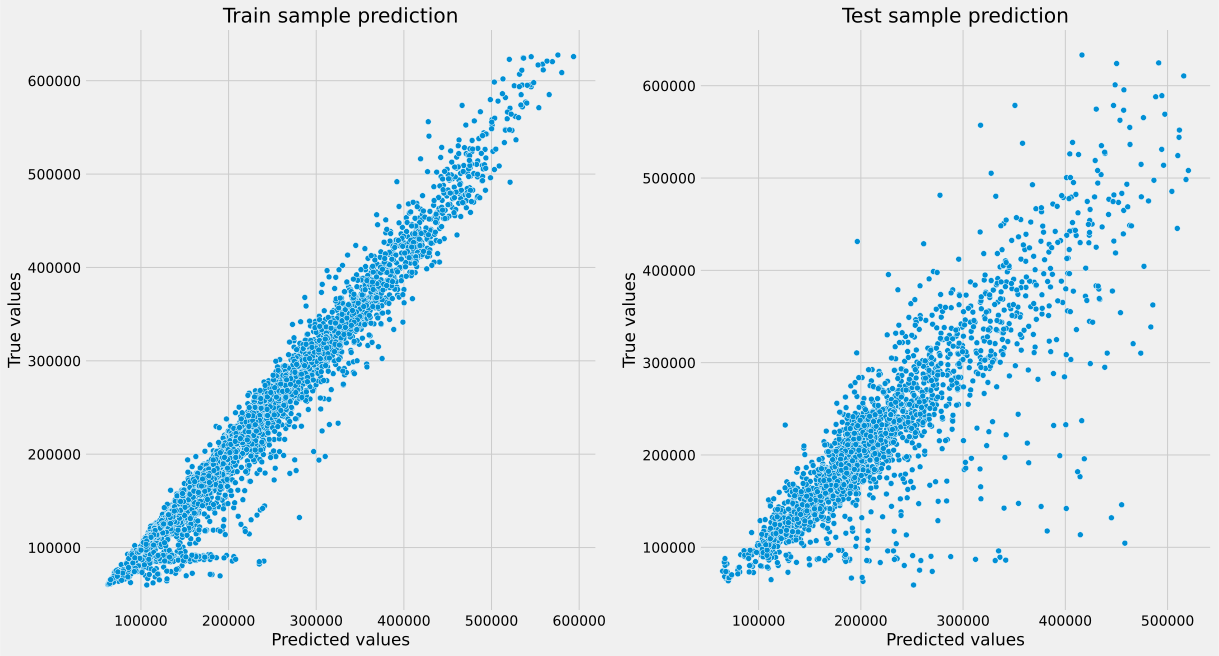

In [58]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Важность признаков

In [59]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.436814
19,DistrictSize,0.215960
14,Social_3,0.049807
4,LifeSquare,0.035337
9,Ecology_1,0.033002
8,HouseYear,0.031864
1,DistrictId,0.027642
0,Id,0.027012
13,Social_2,0.024876
7,HouseFloor,0.022030


In [60]:
joblib.dump(preprocessor, './preprocessor.joblib', compress=True)
joblib.dump(features_gen, './features_gen.joblib', compress=True)
joblib.dump(rf_model, './rf_model.joblib', compress=True)

['./rf_model.joblib']